# Principe

On va appliquer une méthode de classification par machine learning pour essayer de classifier l'état des stations vélib en 5 catégories : 
 - 0 : très faible occupation : risque élevé de ne pas pouvoir retirer un vélo
 - 1 : faible occupation : risque faible de ne pas pouvoir retirer un vélo
 - 2 : occupation moyenne : pas de problème prévu
 - 3 : forte occupation : risque faible de ne pas pouvoir déposer un vélo
 - 4 : très forte occupation : risque élevé de ne pas pouvoir déposer un vélo

On s'inspirera pour ce faire de la méthode de classification vue en cours à l'aide de RandomForestClassifier.



# Import

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

In [10]:
import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


# Chargement des données, et prétraitement : 

La partie qui suit sera plus tard déplacée dans un script à part qui prendra le jour utilisé comme input.

In [6]:
info=pd.read_json('F:/work/download/stations_info.json')
data_info=pd.DataFrame(info.data.stations)

data_rep='F:/work/datasets/'
df=pd.read_csv(data_rep+'stations_status_2023_03_20.csv')

t0=datetime.datetime.combine(df.iloc[0].time.date(), datetime.time()) #datetime at midnight
df['seconds_since_midnight']=(pd.to_timedelta(df.time-t0, unit='s').values/1e9).astype('int')



In [7]:
LIMITS = [5,25,75,95]

conditions = [(df['occupation_prct'] < LIMITS[0])]

for i in range(len(LIMITS)):
    if i == len(LIMITS)-1:
        conditions.append((df['occupation_prct'] >= LIMITS[i]))
    else:
        conditions.append((df['occupation_prct'] >= LIMITS[i]) & (df['occupation_prct'] < LIMITS[i+1]))

# create a list of the values we want to assign for each condition
values = [i for i in range(len(LIMITS)+1)]

# create a new column and use np.select to assign values to it using our lists as arguments
df['occupation_class'] = np.select(conditions, values)



In [4]:
# Version de julien

df1 = dst.getDataset("2023_03_18")
df2 = dst.getDataset("2023_03_19")
df3 = dst.getDataset("2023_03_20")
df4 = dst.getDataset("2023_03_21")


In [5]:
df4.head()

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct,occupation_class
0,213688169,3,1.0,2.0,31,1,1,1,1679351605,2023-03-21 00:00:02,1,00:00:02,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1
1,213688169,3,1.0,2.0,31,1,1,1,1679351605,2023-03-21 00:03:02,1,00:03:02,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1
2,213688169,3,1.0,2.0,31,1,1,1,1679351605,2023-03-21 00:05:02,1,00:05:02,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1
3,213688169,3,1.0,2.0,31,1,1,1,1679351605,2023-03-21 00:07:02,1,00:07:02,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1
4,213688169,3,1.0,2.0,31,1,1,1,1679351605,2023-03-21 00:09:02,1,00:09:02,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1


# Méthode de base, sans occupation aux temps précédents

## Principe

Cette prédiction ne pourrait utiliser que les éléments qui seront connus au moment de la prédiction, soit le lieu, le temps, etc, mais pas le nombre de vélos disponibles. 
Si on veut utiliser ce dernier, il faudrait rajouter la valeur à un temps passé, ce qu'on pourra faire dans la prochaine étape si les données actuelles ne donnent pas de bons résultats. 

## Définition des features et target

In [8]:
df.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct,seconds_since_midnight,occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,0,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,18,1


In [92]:
# feat=['station_id', 'capacity', 'seconds_since_midnight']
feat=['station_id', 'seconds_since_midnight']
target=['occupation_class']

x=df[feat]
y=df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [93]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 144036
1 336875
2 400535
3 130065
4 28099


## Entrainement et prédiction

In [94]:
clf=RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=42)

In [95]:
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.41541058666230607

<AxesSubplot:>

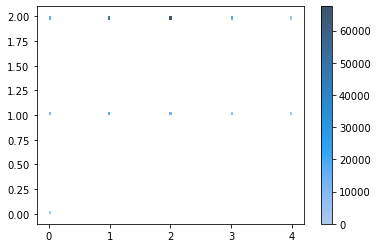

In [96]:
sns.histplot(x=y_test.values.ravel(), y=y_pred, cbar=True)

In [221]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [97]:
print(feat)
clf.feature_importances_

['station_id', 'seconds_since_midnight']


array([0.43704068, 0.56295932])

# Méthode avec la valeur d'occupation à un temps précédent

## Principe

Je vais rajouter le taux d'occupation quelques heures avant le temps de prédiction. Je prendrais 6 heures pour commencer.

Pour simplifier, je prend juste la valeur à minuit pour les temps avant 6h du matin, au lieu de charger les valeurs de la veille.

In [137]:
df2=df.copy()
# df2.loc[df2['seconds_since_midnight'] > 6*3600.,'old_occupancy_class']=
df3=df2[['time','station_id','occupation_class']].copy()
df3['time']=df3['time']+pd.Timedelta(hours=6)
df3=df3.rename(columns={"time": "old_time", "occupation_class": "old_occupation_class"})
#, 'station_id' : 'old_station_id'

df2=pd.merge_asof(df2.sort_values('time'), df3.sort_values('old_time'), by='station_id', left_on='time', right_on='old_time', direction='nearest')

In [138]:
df2

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,seconds_since_midnight,occupation_class,old_time,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,18,1,2023-03-20 06:00:18,1
1,653152142,11,1.0,10.0,9,1,1,1,1679264816,2023-03-20 00:00:18,...,00:00:18,Château - République,48.905928,2.253629,20,55.000000,18,2,2023-03-20 06:00:18,2
2,586539770,9,3.0,6.0,13,1,1,1,1679265054,2023-03-20 00:00:18,...,00:00:18,Marne - Germain Dardan,48.811543,2.303071,22,40.909091,18,2,2023-03-20 06:00:18,2
3,96608796,27,26.0,1.0,0,1,1,1,1679265087,2023-03-20 00:00:18,...,00:00:18,Fille du Calvaire - Turenne,48.862105,2.364960,29,93.103448,18,3,2023-03-20 06:00:18,3
4,82499609,32,27.0,5.0,3,1,1,1,1679265126,2023-03-20 00:00:18,...,00:00:18,Convention - Lourmel,48.842055,2.285991,36,88.888889,18,3,2023-03-20 06:00:18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,653089942,8,2.0,6.0,12,1,1,1,1679351323,2023-03-20 23:58:01,...,23:58:01,Poissonniers - Championnet,48.895433,2.353018,28,28.571429,86281,2,2023-03-20 23:58:37,1
1039606,128841079,1,1.0,0.0,35,1,1,1,1679351366,2023-03-20 23:58:01,...,23:58:01,Cambon - Rivoli,48.866143,2.325180,40,2.500000,86281,0,2023-03-20 23:58:37,2
1039607,220504949,3,2.0,1.0,27,1,1,1,1679351593,2023-03-20 23:58:01,...,23:58:01,Grande Truanderie - Saint-Denis,48.862630,2.349807,33,9.090909,86281,1,2023-03-20 23:58:37,3
1039608,41464928,17,14.0,3.0,45,1,1,1,1679351580,2023-03-20 23:58:01,...,23:58:01,Sèvres - Lecourbe,48.844768,2.311009,62,27.419355,86281,2,2023-03-20 23:58:37,1


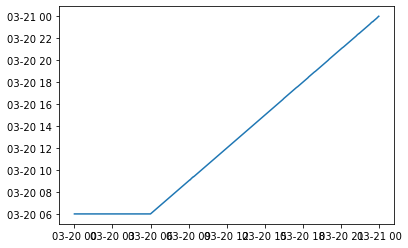

In [139]:
plt.plot(df2.time, df2.old_time)

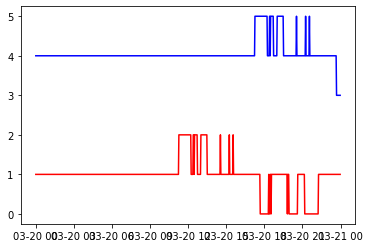

In [142]:
ind=(df2.station_id == df2.loc[0,'station_id'])

plt.plot(df2[ind].time, df2[ind].occupation_class, color='r')
plt.plot(df2[ind].time, df2[ind].old_occupation_class+3, color='b')


## Définition des features et target

In [143]:
df2.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,seconds_since_midnight,occupation_class,old_time,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,18,1,2023-03-20 06:00:18,1


In [154]:
feat=['station_id', 'seconds_since_midnight','lat', 'lon', 'old_occupation_class']
target=['occupation_class']

x=df2[feat]
y=df2[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [145]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 144036
1 336875
2 400535
3 130065
4 28099


## Entrainement et prédiction

In [155]:
clf2=RandomForestClassifier(max_depth=2, random_state=42)
clf2.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=42)

In [159]:
y_pred = clf2.predict(x_test)
accuracy_score(y_test, y_pred)

0.522960533276902

In [220]:
# sns.histplot(x=y_test.values.ravel(), y=y_pred, cbar=True)

<AxesSubplot:>

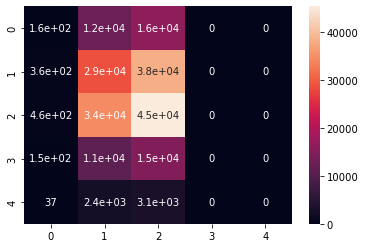

In [158]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [160]:
print(feat)
clf2.feature_importances_

['station_id', 'seconds_since_midnight', 'lat', 'lon', 'old_occupation_class']


array([0.07836968, 0.19854182, 0.07330987, 0.01298314, 0.63679549])

# Méthode avec la valeur d'occupation à un temps précédent (cyclicité bien prise en compte)

Copie de la partie précédente, mais les 6 premières heures de la journée utilisent les temps 18h après au lieu de minuit

## Principe

Je vais rajouter le taux d'occupation quelques heures avant le temps de prédiction. Je prendrais 6 heures pour commencer.

Pour simplifier, je prend juste la valeur à minuit pour les temps avant 6h du matin, au lieu de charger les valeurs de la veille.

In [191]:
df4=df.copy()
# df2.loc[df2['seconds_since_midnight'] > 6*3600.,'old_occupancy_class']=
df3=df4[['hour','station_id','occupation_class']].copy()
df4['hour']=df4['hour']+pd.Timedelta(hours=0) 
df3['hour']=df3['hour']+pd.Timedelta(hours=6)
df3['hour']=df3['hour'].apply(lambda x:x-pd.Timedelta(days=x.days))
df3=df3.rename(columns={"hour": "old_hour", "occupation_class": "old_occupation_class"})
#, 'station_id' : 'old_station_id'

In [206]:
df4=pd.merge_asof(df4.sort_values('hour'), 
                  df3.sort_values('old_hour'), 
                  by='station_id', left_on='hour', right_on='old_hour', direction='nearest')

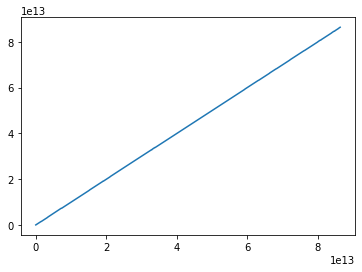

In [207]:
plt.plot(df4.hour, df4.old_hour)

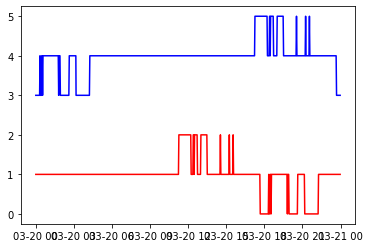

In [210]:
ind=(df4.station_id == df4.loc[0,'station_id'])

plt.plot(df4[ind].time, df4[ind].occupation_class, color='r')
plt.plot(df4[ind].time, df4[ind].old_occupation_class+3, color='b')


## Définition des features et target

In [211]:
df4.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,seconds_since_midnight,occupation_class,old_hour,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,0 days 00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,18,1,0 days 00:00:37,0


In [212]:
feat=['station_id', 'seconds_since_midnight', 'old_occupation_class']
target=['occupation_class']

x=df2[feat]
y=df2[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [213]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 144036
1 336875
2 400535
3 130065
4 28099


## Entrainement et prédiction

In [214]:
clf4=RandomForestClassifier(max_depth=2, random_state=42)
clf4.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=42)

In [215]:
y_pred = clf4.predict(x_test)
accuracy_score(y_test, y_pred)

0.5230663421860121

In [219]:
# sns.histplot(x=y_test.values.ravel(), y=y_pred, cbar=True)

<AxesSubplot:>

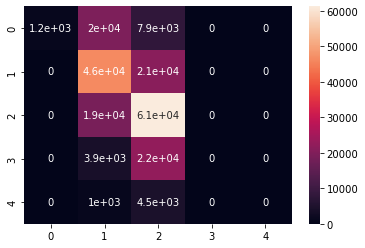

In [217]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [218]:
print(feat)
clf4.feature_importances_

['station_id', 'seconds_since_midnight', 'old_occupation_class']


array([0.20508767, 0.29210992, 0.50280242])

# Utilisation d'un gradient boosting classifier

## Principe

On veut voir si les limites rencontrées sont dues en partie au modèle de machine learning utilisé. Beaucoup d'exemples en ligne de classifieur utilisent un gradient boosting classifier à la place d'un random forest classifier donc on a choisi celui-ci.

## Définition des features et target

In [6]:
df_main=df3.copy()
# df2.loc[df2['seconds_since_midnight'] > 6*3600.,'old_occupancy_class']=
df_join=df_main[['hour','station_id','occupation_class']].copy()
df_main['hour']=df_main['hour']+pd.Timedelta(hours=0) 
df_join['hour']=df_join['hour']+pd.Timedelta(hours=6)
df_join['hour']=df_join['hour'].apply(lambda x:x-pd.Timedelta(days=x.days))
df_join=df_join.rename(columns={"hour": "old_hour", "occupation_class": "old_occupation_class"})
#, 'station_id' : 'old_station_id'

In [7]:
df_main=pd.merge_asof(df_main.sort_values('hour'), 
                  df_join.sort_values('old_hour'), 
                  by='station_id', left_on='hour', right_on='old_hour', direction='nearest')

In [11]:
df=df_main

feat=['station_id', 'seconds_since_midnight', 'old_occupation_class']
target=['occupation_class']

x=df[feat]
y=df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Entrainement et prédiction

In [13]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)


In [14]:
clf.fit(x_train, y_train.values.ravel())

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [18]:
with open('.model/gradboost_v1.pkl', 'wb') as file_pkl :
    pickle.dump(clf, file_pkl)

In [19]:
y_pred=clf.predict(x_test)

clf.score(x_test, y_test.values.ravel())


0.4818008676330547

<AxesSubplot:>

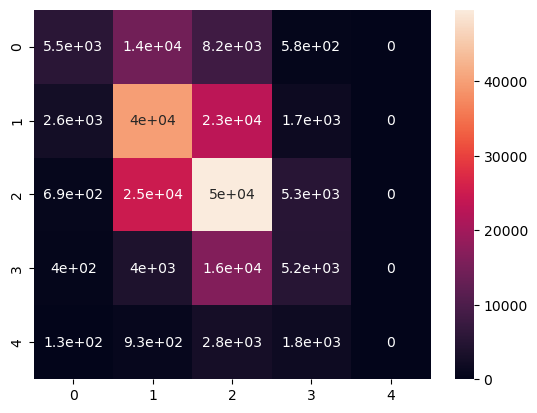

In [20]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

<AxesSubplot:>

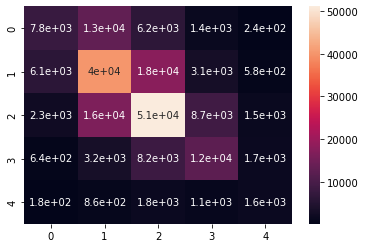

In [238]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [241]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.27      0.34     28603
           1       0.55      0.59      0.57     67588
           2       0.60      0.64      0.62     80003
           3       0.46      0.48      0.47     26206
           4       0.29      0.29      0.29      5522

    accuracy                           0.54    207922
   macro avg       0.47      0.45      0.46    207922
weighted avg       0.54      0.54      0.54    207922



# Utilisation d'une série temporelle pour l'entrainement

# Classification des stations

On veut voir si on peut trouver des similarités entre certaines stations. On va regarder les corrélations entre les séries temporelles pour chaque station.

In [24]:
# info=pd.read_json('./data/stations_info.json')
# data_info=pd.DataFrame(info.data.stations)
# station_list=list(data_info.station_id)

In [188]:
df=df3
df=df.dropna()
df=df.drop(df[df['is_renting'] == 0].index)
# df = df.drop(df[<some boolean condition>].index)

KeyError: True

In [183]:
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])


In [184]:
Nst, Nt

(1418, 712)

In [185]:
for i in range(len(station_list)) :
    station_timeserie[i,:]=df[df['station_id'] == station_list[i]].occupation_class
    
pd_timeserie=pd.DataFrame(columns=station_list)
for i in range(Nst) :
    pd_timeserie[station_list[i]]=station_timeserie[i,:]

ValueError: could not broadcast input array from shape (670,) into shape (712,)

In [187]:
station_timeserie[i,:].shape

(712,)

In [159]:
co=pd_timeserie.corr()

<AxesSubplot:ylabel='Count'>

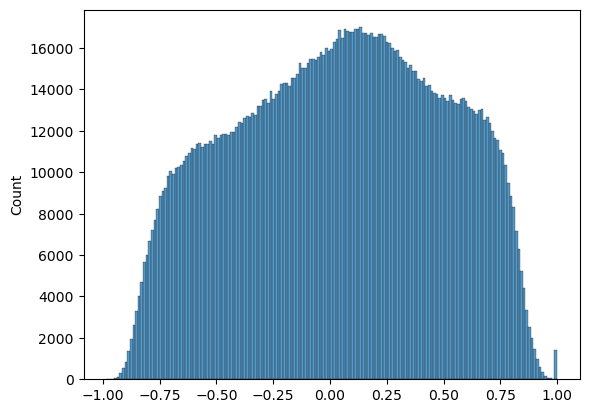

In [160]:
sns.histplot(x=np.reshape(co.values, Nst*Nst))



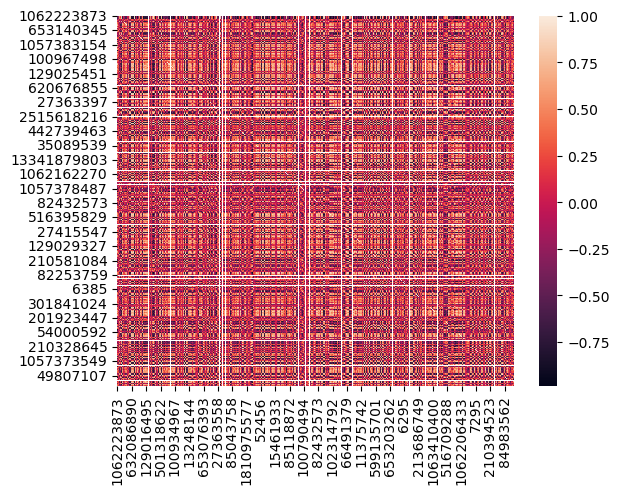

In [161]:
sns.heatmap(co);

In [162]:
pd_timeserie2=pd_timeserie.copy()

In [163]:
col=pd_timeserie2.columns.values
col_sorted=[x for _, x in sorted(zip(co.sum().values, col))]
# col_sorted=pd_timeserie2.columns.values
col_sorted

[1064000778,
 49423507,
 128920403,
 95073815,
 1062797394,
 34300292,
 1057319366,
 129026597,
 213868408,
 48800374,
 210753033,
 210581084,
 1002059045,
 419991048,
 323616530,
 100759356,
 653076373,
 84979504,
 27415012,
 75345531,
 2515802454,
 653046029,
 66489651,
 1062671597,
 593238093,
 129029327,
 82588656,
 99798962,
 213875650,
 54000592,
 128834707,
 120564786,
 54000552,
 54000554,
 506455295,
 66491389,
 237624030,
 478732841,
 213685863,
 94250567,
 6515,
 6294,
 311153993,
 129014600,
 338853596,
 82569809,
 128882438,
 394404659,
 276989966,
 54000543,
 473204291,
 100893610,
 27363256,
 128841079,
 653114003,
 1558958733,
 60667075,
 54000551,
 27363389,
 210395439,
 1057405802,
 1062807847,
 569583918,
 54000466,
 66491390,
 72765603,
 653080383,
 82387816,
 210582231,
 653031913,
 100798076,
 54001189,
 653197324,
 75641607,
 653035822,
 100859941,
 544249939,
 84986959,
 66491366,
 38327,
 549480297,
 210567545,
 54000593,
 128989986,
 82336035,
 88140066,
 9651

In [164]:
pd_timeserie2 = pd_timeserie2.reindex(columns=col_sorted)
# pd_timeserie2=pd_timeserie2.sort()

In [165]:
co2=pd_timeserie2.corr()

<AxesSubplot:>

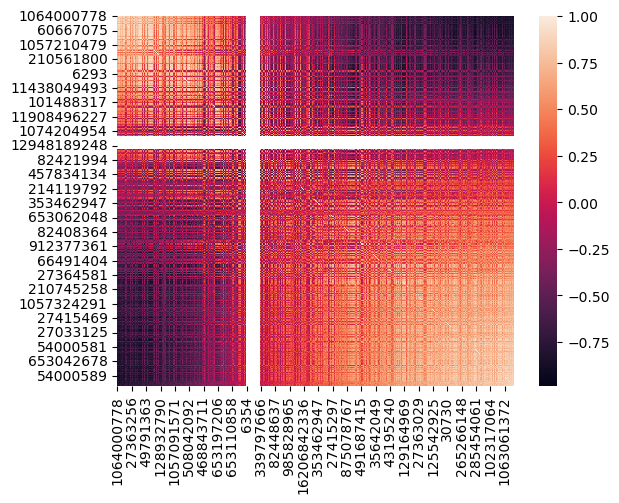

In [166]:
sns.heatmap(co2)


In [ ]:
stat_grp1=col_sorted[0:20]
stat_grp2=col_sorted[-21:-1]

df[df['station_id'].isin(stat_grp1)].name.unique()
#Lieux d'arrivées le matin

In [169]:
df[df['station_id'].isin(stat_grp2)].name.unique()
#Lieux de retour


array(['Pajol - Place Herbert', 'Adolphe Lalyre - Armand Silvestre',
       'Gabriel Péri - Francisco Ferrer',
       'Gabriel Péri - Danielle Casanova', 'Cordelières - Arago',
       'Place Albert Kahn', 'Morillons - Dantzig', 'Mairie de Bagnolet',
       'Mairie du 12ème', 'Gambetta - Saint Fargeau',
       'Etienne Dolet - Place Maurice Chevalier',
       'Mûriers - Père Lachaise', 'LCL Campus - Place Oscar Niemeyer',
       'Pierre Joseph Desault', 'Félix Faure - Convention',
       'Borrégo - Gambetta', 'Théâtre - Lourmel', 'Belliard - Damrémont',
       'Berthier - Place Stuart Merril', 'Exelmans - Michel-Ange'],
      dtype=object)

In [ ]:
stat_grp1=

In [ ]:
#Afficher les points de la catagorie 

count    1.024568e+06
mean     9.852191e-01
std      1.206748e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

In [189]:
df

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,0,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,18
1,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:02:17,0,00:02:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,137
2,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:04:18,0,00:04:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,258
3,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:06:17,0,00:06:17,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,377
4,213688169,5,2.0,3.0,30,1,1,1,1679264946,2023-03-20 00:08:18,0,00:08:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714,1,498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:49:01,0,23:49:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,85741
1039606,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:52:01,0,23:52:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,85921
1039607,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:54:01,0,23:54:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,86041
1039608,315022587,1,0.0,1.0,63,1,1,1,1679351341,2023-03-20 23:56:01,0,23:56:01,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,86161


# Deep learning

In [ ]:
#On veut voir si on peut appliquer un RNN 